## InfiMM-Eval数据集

### 1. 加载数据集

In [23]:
import json
import pandas as pd

# 1. 加载 JSON 文件
with open("datasets/InfiMM-Eval/core-mm-wo-answer.json", "r") as f:
    raw_data = json.load(f)

# 2. 将 dict 转成 list（按 key 排序）
samples = [raw_data[k] for k in sorted(raw_data, key=lambda x: int(x))]

# 3. 转成 pandas DataFrame（你可以选取需要的字段）
df = pd.DataFrame(samples)

# 4. 展示前几行
print(df.head())

                                                 URL  \
0  [https://i.pinimg.com/474x/00/d5/e9/00d5e92cd7...   
1  [https://static.independent.co.uk/s3fs-public/...   
2  [https://i.pinimg.com/564x/50/4d/98/504d98f9db...   
3  [https://i.pinimg.com/564x/1a/37/67/1a3767d9a5...   
4  [https://i.pinimg.com/474x/53/d7/d2/53d7d2f33b...   

                                   Image path  \
0  [fea128d4-bab4-4c2c-9ee0-faaee9091627.png]   
1  [4badc7e5-7713-447e-aa7f-b94164650279.png]   
2  [3aa39c3c-1d8b-4b2a-b883-138d2b52e69d.png]   
3  [7a775b8e-58b9-4fcf-bacf-4ab6ab2459ad.png]   
4  [b2495210-2438-4435-8d48-28acb6b0bc8e.png]   

                                            Question   Category  \
0  Do the foreground and background look consiste...  Deductive   
1  If I want to read a Shakespearean tragedy, whi...  Deductive   
2  If I like paintings with religious theme, whic...  Deductive   
3  If I'm observing Mars, which celestial body am...  Deductive   
4   If I want to harvest grapes f

### 2. 数据清洗&保存

In [24]:
df["image_url"] = df["URL"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df["image_name"] = df["Image path"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

- 保存为excel表格

In [25]:
df[["Question", "Category", "Complexity", "image_url", "image_name"]].to_excel("datasets/InfiMM-Eval/infimm-eval-cleaned.xlsx", index=False) 

### 3. 提取出20个实验数据

In [26]:
import pandas as pd

# 1. 读取原始表格
df = pd.read_excel("datasets/InfiMM-Eval/infimm-eval-cleaned.xlsx")

# 2. 定义目标样本数 & 每个难度的数量
target_total = 20
complexity_quota = {
    "Easy": 7,
    "Moderate": 8,
    "Hard": 5
}

# 3. 分别从每个难度中采样
samples = []
for level, quota in complexity_quota.items():
    subset = df[df["Complexity"] == level]
    n = min(quota, len(subset))  # 避免超抽
    sample = subset.sample(n=n, random_state=42)
    samples.append(sample)

# 4. 合并所有难度
sampled = pd.concat(samples, ignore_index=True)

# 5. 如果还不足 target_total，就从剩下的 pool 中补足
needed = target_total - len(sampled)
if needed > 0:
    pool = df[~df.index.isin(sampled.index)]
    extra = pool.sample(n=needed, random_state=42)
    sampled = pd.concat([sampled, extra], ignore_index=True)

# 6. 打乱顺序（可选）
sampled = sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. 保存最终实验样本集
sampled.to_excel("datasets/InfiMM-Eval/infimm-eval-selected.xlsx", index=False)

### 4. 查看问题类型的分布

- 原始数据集中不同问题类型的分布

In [ ]:
import pandas as pd

# 1. 查看所有出现过的问题类型（种类）
categories = df["Category"].unique()
print("所有问题类型种类：")
print(categories)

# 2. 查看每种类型的数量（分布）
category_counts = df["Category"].value_counts()
print("\n问题类型分布：")
print(category_counts)

所有问题类型种类：
['Deductive' 'Abductive' 'Analogical']

问题类型分布：
Category
Deductive     181
Abductive      49
Analogical     49
Name: count, dtype: int64


- 可视化

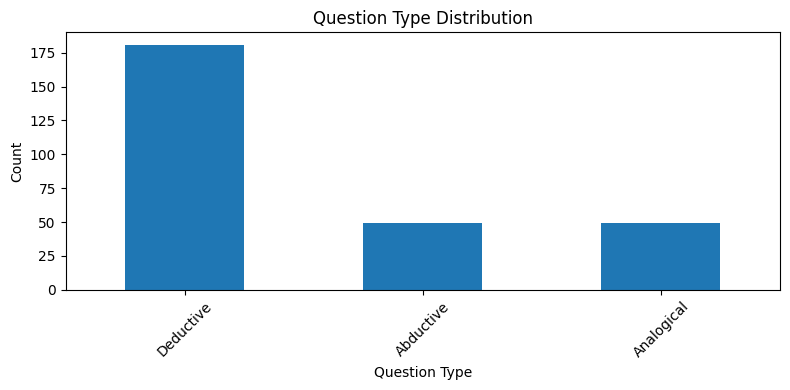

In [30]:
import matplotlib.pyplot as plt

df["Category"].value_counts().plot(kind='bar', figsize=(8, 4), title="Question Type Distribution")
plt.xlabel("Question Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()